<a href="https://colab.research.google.com/github/elmomote/DL2024-FacialKeypointDetectionProject/blob/main/%5BF24_DL%5D_Facial_Keypoint_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **The Project**

The Facial Keypoint Detection Competition from Kaggle consists of creating a model that receives grayscale images of shape 96x96 and make 30 predictions based on those images.

### **The Plan**

The plan in this project is to split up and make two models. Try our best, make some good documentation, and at the end. Observe the best out of both models to make one final model.

# Loading Data set from Kaggle

In [5]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c facial-keypoints-detection
!unzip facial-keypoints-detection.zip
!unzip training.zip
!unzip test.zip


Saving kaggle.json to kaggle.json
 94% 72.0M/76.3M [00:00<00:00, 110MB/s] 
100% 76.3M/76.3M [00:00<00:00, 93.9MB/s]
Archive:  facial-keypoints-detection.zip
  inflating: IdLookupTable.csv       
  inflating: SampleSubmission.csv    
  inflating: test.zip                
  inflating: training.zip            
Archive:  training.zip
  inflating: training.csv            
Archive:  test.zip
  inflating: test.csv                


## Sample Image

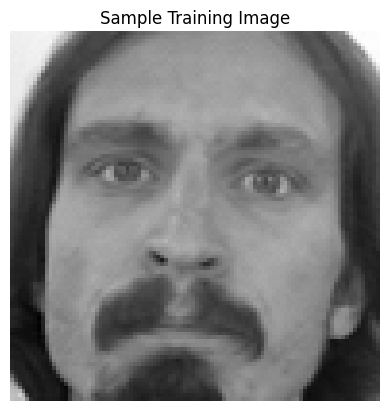

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('training.csv')
data['Image'] = data['Image'].apply(lambda x: np.fromstring(x, sep=' '))
image_index = 0  # Change this to display a different image
image = data['Image'][image_index].reshape(96, 96)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Sample Training Image")
plt.show()


## Sample Image with Key points

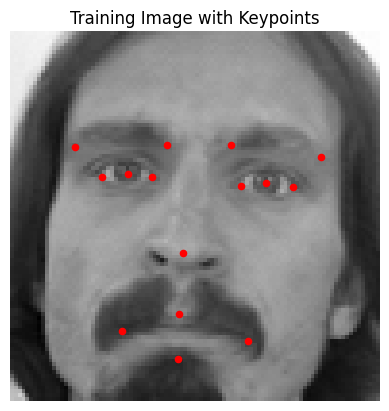

In [ ]:
keypoints = data.iloc[image_index, :-1].values  # All columns except the 'Image'
keypoints = keypoints.astype(float).reshape(-1, 2)  # Reshape into (x, y) pairs

plt.imshow(image, cmap='gray')
plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, c='red', marker='o')
plt.axis('off')
plt.title("Training Image with Keypoints")
plt.show()


# Model 1
Conducted by Anaiah Quinn

In [ ]:
# Load and preprocess data
data = pd.read_csv('training.csv')
data['Image'] = data['Image'].apply(lambda x: np.fromstring(x, sep=' '))
data.dropna(inplace=True)  # Drop rows with missing keypoints

# Prepare input and output
images = np.stack(data['Image'].values).reshape(-1, 96, 96, 1) / 255.0  # Normalize pixel values
keypoints = data.drop(columns=['Image']).values  # Keypoints as targets

# Split into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, keypoints, test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(30)  # 15 keypoints * 2 coordinates
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on validation data
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

# Visualize predictions
def visualize_predictions(index):
    img = X_val[index].reshape(96, 96)
    true_keypoints = y_val[index].reshape(-1, 2)
    predicted_keypoints = model.predict(X_val[index:index+1]).reshape(-1, 2)

    plt.imshow(img, cmap='gray')
    plt.scatter(true_keypoints[:, 0], true_keypoints[:, 1], c='green', label='True', s=20)
    plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='red', label='Predicted', s=20)
    plt.legend()
    plt.title('True vs Predicted Keypoints')
    plt.axis('off')
    plt.show()

# Visualize predictions for a random sample
visualize_predictions(0)  # Change the index to view other samples


# Model 2
Conducted by Alan Gonzalez

In [53]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Preparing the training data

In [54]:
# Get input data from the training set
training_data = pd.read_csv('training.csv')

'''
  FOR IMAGE INPUTS
'''
# Separate each data input by spaces
training_data['Image']  = training_data['Image'].apply(lambda x: np.fromstring(x, sep=' '))

# Convert data to image shape
training_data['Image'] = training_data['Image'].apply(lambda x: x.reshape(96, 96))
training_images = np.array(training_data['Image'].tolist())

'''
  FOR COORDINATE OUTPUTS
'''
coordinate_columns = training_data.columns.difference(['Image'])
training_coordinates = np.array(training_data[coordinate_columns])

Visualize for sanity. With and without keypoints.

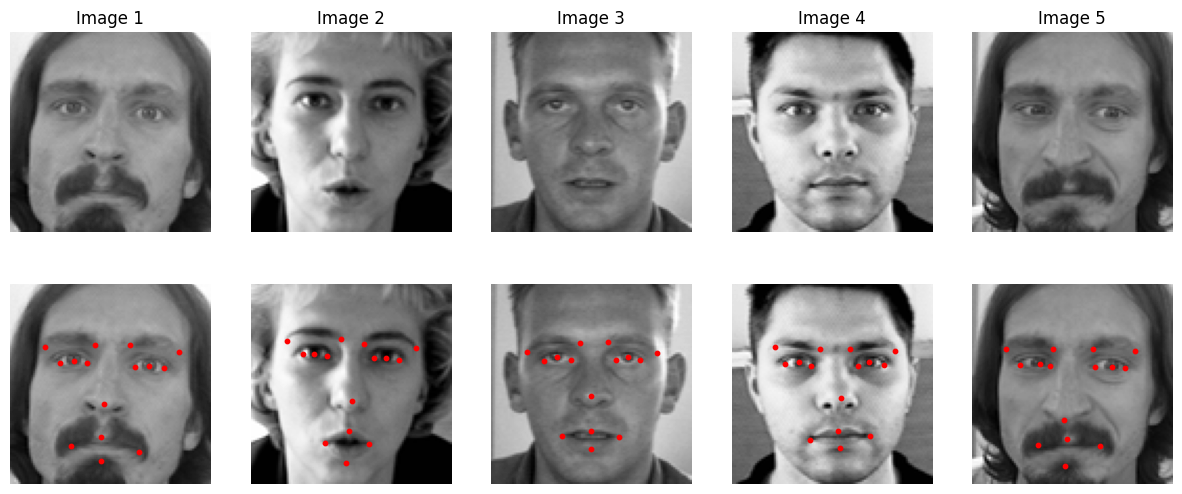

In [55]:
import matplotlib.pyplot as plt

# Number of examples to display
num_examples = 5

# Set up the figure with two rows: one for images, one for images with keypoints
fig, axes = plt.subplots(2, num_examples, figsize=(15, 6))

for i in range(num_examples):
    # Select an image and its keypoints
    image = training_images[i]
    keypoints = training_coordinates[i]

    # First row: Display the image without keypoints
    ax = axes[0, i]
    ax.imshow(image, cmap='gray')
    ax.axis('off')  # Turn off the axis
    ax.set_title(f"Image {i+1}")

    # Second row: Display the image with keypoints
    ax = axes[1, i]
    ax.imshow(image, cmap='gray')
    for j in range(0, len(keypoints), 2):  # Loop through x, y pairs
        x = keypoints[j]
        y = keypoints[j + 1]
        if not np.isnan(x) and not np.isnan(y):  # Skip missing keypoints
            ax.scatter(x, y, c='red', s=10)  # Plot keypoints as red dots
    ax.axis('off')  # Turn off the axis

# Adjust layout to avoid overlap
plt.show()


Create a 80/20 split on the training data. Only use test data when the model seems promising.

In [56]:
split_index = int(len(training_images) * 0.8)

x_train = training_images[:split_index]
x_val = training_images[split_index:]
y_train = training_coordinates[:split_index]
y_val = training_coordinates[split_index:]

print('Training inputs shape:', x_train.shape)
print('Validation input shape:', x_val.shape)
print('Training outputs shape:', y_train.shape)
print('Validation output shpe:', y_val.shape)

Training inputs shape: (5639, 96, 96)
Validation input shape: (1410, 96, 96)
Training outputs shape: (5639, 30)
Validation output shpe: (1410, 30)


Creating a simple convolutional model with 32, 16, and 8 filters. Adding option to modify filters if needed.

In [57]:
def m2_simple_convolution(filters = [32, 16, 8]):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape = (96, 96, 1)))

  for num_filters in filters:
    model.add(
      tf.keras.layers.Conv2D(
        num_filters,
        kernel_size = (3, 3),
        padding = 'same'
      )
    )

  # Final layer to get the same output shape
  model.add(
    tf.keras.layers.Conv2D(
      1,
      kernel_size = (3, 3),
      padding = 'same'
    )
  )

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(30, activation = 'sigmoid'))

  return model

In [58]:
m2_attempt_1 = m2_simple_convolution()
m2_attempt_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 96, 96, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 96, 96, 1)           │              73 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │         276,510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 282,687 (1.08 MB)

 Trainable params: 282,687 (1.08 MB)

 Non-trainable params: 0 (0.00 B)